In [1]:
from __future__ import print_function, division

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import timeit
#from sklearn.cross_validation import train_test_split

In [3]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix

# Build Models from icd9-code features created using Likelihood model


This notebook uses the data : **data tables** : new_alive, new_icd9


\\[\frac{P(death | icd9 =x) }{P(survival | icd9 =x)} = prior* \frac{ P(icd9 = x | death) }{P(icd9 = x | survival)} \\]

\\[  = prior* \frac{ \frac{count Deaths}{All Deaths}} {\frac{count Survival}{All Survival}} \\]



In [237]:
# download the dataframe for modeling
df = pd.read_csv('mimic_data/data_model1.csv')

#downoald the diagnoses_key 
diagnoses_key = pd.read_csv('mimic_data/diagnoses_key.csv')

In [5]:
df[:3]

,hadm_id,subject_id,expire_flag,gender,admission_type,diagnosis,age,07031,07041,1481,...,85205,85225,9878,99685,99688,E9278,V1062,V143,V4578,V568
0,121205,91,1,F,EMERGENCY,FEVER,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,183686,94,1,M,EMERGENCY,SEPSIS,74.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,140037,94,1,M,EMERGENCY,PNEUMONIA,74.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.admission_type.unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT', 'NEWBORN'], dtype=object)

In [7]:
df.dropna(inplace=True)

Do I have any variables where I have not enough data points? For instance, maybe fore one or two diagnoses maybe I only have 2 cases, is that enough to establish odds of survival? 

- Count the number of 1's or instances/occurances, of each diagnosis
- Count the number of rows with Expire/not flag

In [8]:
exclude = ['hadm_id', 'subject_id', 'expire_flag', 'gender', 'admission_type',
       'diagnosis', 'age']
diagnosis_codes = df.columns.tolist()
diagnosis_codes
#diagnosis_codes.remove('hadm_id','age')

diagnosis_codes = [x for x in diagnosis_codes if x not in exclude]

In [9]:
len(diagnosis_codes)

47

In [15]:
diagnosis_codes[:2]

['07031', '07041']

## Understanding diagnosis codes
There are 47 diagnosis codes, and the model is built and tested on these 47;

Furthermore the counts of fatal cases are at least 11 for each of these codes; Codes with fewer than 11 cases have been exlcuded previously in the EDA notebook 


In [56]:
#df.loc[(df['07031'].nonzero()) & 
#df.loc[(df['expire_flag']==1) ]
""" use query: find nonzero values AND expire flag
"""
#df.query('expire_flag==1 and df['07031'].nonzero()')
a = df.loc[(df['07031'].nonzero() )]#) and (df.expire_flag ==1)]
#df.loc[(df['expire_flag']==1) ]

In [109]:
#df.loc[(df['07031']==1.0) & (df['expire_flag']==0)]
df.loc[(df['07031']==1.0) & (df['expire_flag']==0)]['hadm_id'].count()

1

In [92]:
#df.loc[(df['07031']==1.0)]
### RETURNS: 18 rows × 54 columns

In [71]:
df.loc[df['07031']==0.0]['hadm_id'].count()

58931

In [112]:
fatal_cases = []
nonfatal = []
for a in diagnosis_codes:
    # this should be JUST numer of occurances 
    # Fatal
    count_f = df.loc[(df[a]==1.0) & (df['expire_flag']==1)]['hadm_id'].count()
    fatal_cases.append(count_f)
    # NONfatal
    count_nf = df.loc[(df[a]==1.0) & (df['expire_flag']==0)]['hadm_id'].count()
    nonfatal.append(count_nf)
 


In [115]:
#list(zip(fatal_cases, nonfatal))

In [116]:
df_count = pd.DataFrame(list(zip(fatal_cases,nonfatal)),
                        index=diagnosis_codes, columns=['count_fatal', 'nonfatal'])

In [121]:
"""
    print total fatal values for each diagnosis
"""
df_count.sort_values('count_fatal',ascending=False)

,count_fatal,nonfatal
1972,275,14
51181,163,16
99685,160,24
1984,119,9
485,95,7
20510,90,10
58281,84,37
1971,77,5
85225,49,2
V4578,43,6


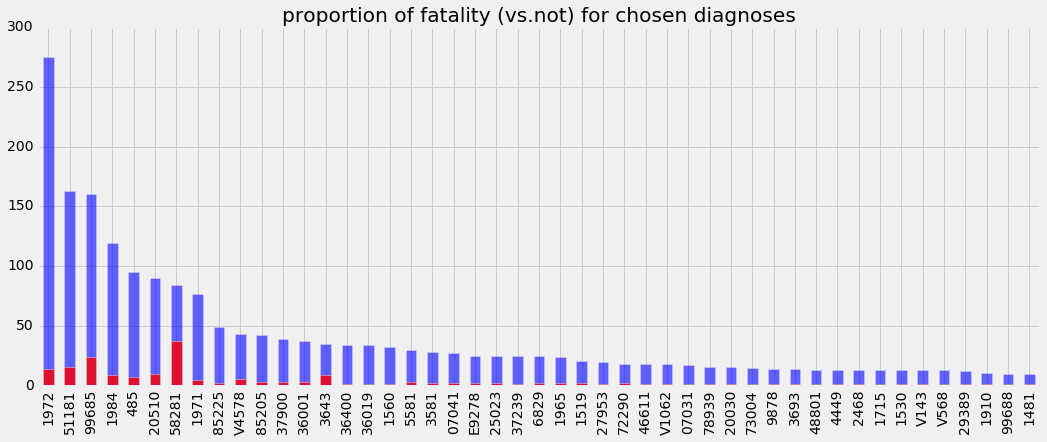

In [142]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (16,6))
df_count.sort_values('count_fatal',ascending=False).count_fatal.plot(kind='bar', color='blue',alpha=0.6)
df_count.sort_values('count_fatal',ascending=False).nonfatal.plot(kind='bar', color='red', alpha=0.8)
plt.title('proportion of fatality (vs.not) for chosen diagnoses')
#plt.savefig('model_diagnosis_proportion')

So there is an imbalance of classes, in fact the majority of the chose diseases appear to be more deadly than survivable. 
**with 50 diseases** it appears the choice of diagnoses tends toward fatal

## Admission Type:

* the choice of Admission Type/Emergency and Elective has a dependency with target variable: expire_tag
* encode Admission Type and gender into numeric types

In [143]:
# ############ Admission_type into categorical 
cols = ['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']
nums = [0, 1, 2, 3 ]
print(df.admission_type.unique())

df.admission_type.replace(cols, nums, inplace=True)

['EMERGENCY' 'ELECTIVE' 'URGENT' 'NEWBORN']


In [144]:
########### Gender ##########
gen = ["M", "F"]
n_g = [0,1]
df.gender.replace(gen, n_g, inplace=True)

In [ ]:
#df.info()

In [147]:
#df

In [145]:
"""
    FUNCTION FOR EVALUATION 
    build pr-curve comparing ground truth with model score
    truthvec - truth vectore
    scorevec - score vector
    s - type of classifier , eg. 'logistic', 'random forest' etc.
"""

def pr_curve(truthvec, scorevec, s, digit_prec=2):
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.plot(precisionvec,recallvec, label=s)
    plt.axis([0, 1, 0, 1])
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend()
    return (recallvec, precisionvec, threshvec)

In [148]:
# exclude diagnosis from the fit
df.columns.values
cols = ['gender', 'admission_type',
       'age', '07031', '07041', '1481', '1519', '1530',
       '1560', '1715', '1910', '1965', '1971', '1972', '1984', '20030',
       '20510', '2468', '25023', '27953', '29389', '3581', '36001',
       '36019', '36400', '3643', '3693', '37239', '37900', '4449', '46611',
       '485', '48801', '51181', '5581', '58281', '6829', '72290', '73004',
       '78939', '85205', '85225', '9878', '99685', '99688', 'E9278',
       'V1062', 'V143', 'V4578', 'V568'] # 'hadm_id', 'subject_id', 'expire_flag','diagnosis'

X = df.loc[:, cols]
y = df.loc[:,'expire_flag']

# Models and variations:
   #### 1. Logistic Model: Gender, Age, Admission type + ICD9 codes
            - pr-curve
            - roc-score
            - confusion matrix
            - classification report ( f1-score = 0.72
   #### 2. Random Forest Classifier
   #### 3. 

In [233]:
diagnoses_key.info()
len(diagnoses_key.icd9_code.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6984 entries, 0 to 6983
Data columns (total 9 columns):
icd9_code      6984 non-null object
row_id         6984 non-null int64
subject_id     6984 non-null int64
hadm_id        6984 non-null int64
seq_num        6984 non-null float64
row_id.1       6841 non-null float64
icd9_code.1    6841 non-null object
short_title    6841 non-null object
long_title     6841 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 491.1+ KB


6984

In [273]:
"""
    input a model instance (after the model has been trained)
    use the .feature_importances_ attribute to extract
    * the feature importances of the model output
    then merges with diagnoses_key to get the text of the diagnoses icd9 code
"""

def get_feature_importances(model):
    #convert feature variables and model 
    a = list(zip(X.columns, model.feature_importances_))
    a.sort(key=lambda tup: tup[1])
    
    tmp = pd.DataFrame(a, columns=['icd9_code','importance'])
    tmp = tmp.sort_values('importance', ascending=False)
    model_importance = tmp.merge(diagnoses_key.drop_duplicates(), on=['icd9_code'],how='left')
    model_importance = model_importance.rename(columns={'icd9_code':'feature'})

    return model_importance

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=4444 )

In [176]:
"""
    make an instance of a Logistic Regression Model 
"""

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [177]:
y_pred_lr = lr_model.fit(X_train, y_train).predict_proba(X_test)

In [178]:
lr_vec = y_pred_lr[:,1]

In [179]:
"""
    ValueError: Can't handle mix of binary and continuous-multioutput
"""
#accuracy_score(y_test, y_pred_lr, normalize=True)

"\n    ValueError: Can't handle mix of binary and continuous-multioutput\n"

In [180]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,lr_vec)


0.7851077779047417

/Users/billierolih/anaconda/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/Users/billierolih/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


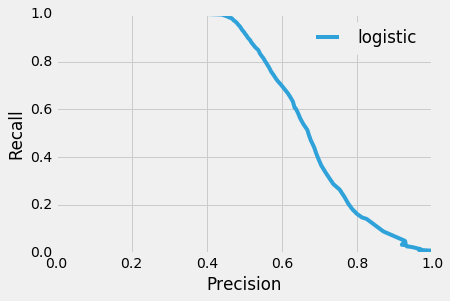

In [181]:
pr_curve(y_test, lr_vec,'logistic');

## Evaluation
prediction = predicts the outcome vectors 

### Confusion matrix 

In [182]:
# for confusion matrix use method .predict, to get the predicted label, not probability
prediction = lr_model.fit(X_train, y_train).predict(X_test)
accuracy = accuracy_score(y_test, prediction, normalize=True)

In [183]:
"""
    Log-loss
     appropriate performance measure when you're model output is the
     probability of a binary outcome.
     ... what is 9.74  
"""
log_loss(y_test, prediction) #make sure have prediction variable 

9.741654903963198

##### Log Loss is really high
suggesting probably many mis-labeled data?  Log Loss higher than 1 usually indicates a very mis-labeled data set 

In [184]:
prediction

array([1, 0, 0, ..., 0, 0, 0])

In [185]:
prediction.size

17685

In [187]:
#imported above
cm = confusion_matrix(y_test, prediction)
cm

array([[8759, 2189],
       [2799, 3938]])

CPU times: user 209 ms, sys: 35.9 ms, total: 245 ms
Wall time: 239 ms


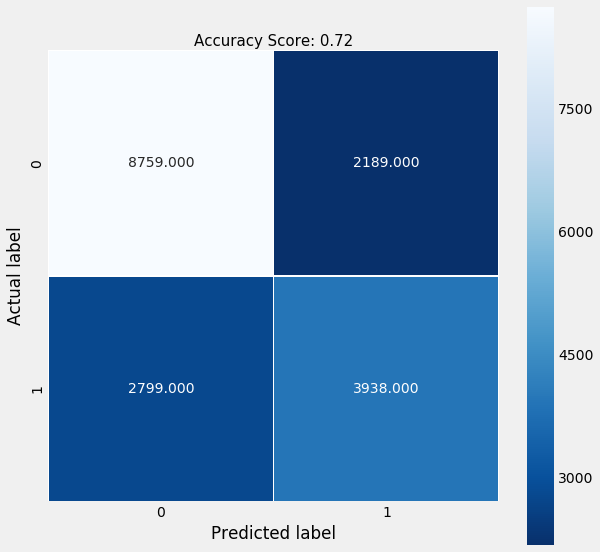

In [188]:
%%time
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy,2))
plt.title(all_sample_title, size = 15);

Model performs best in the accuracy of true positives, followed by true negatives

Model has somewhat higher number of false negatives (than false positives) 

Model under-estimates and mis-classifies fatal cases at higher rates than non-fatal. 

## Classification report 

In [189]:
from sklearn.metrics import classification_report

y_pred = prediction
y_true = y_test
target_names =  ['fatal', 'non-fatal']
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

      fatal       0.76      0.80      0.78     10948
  non-fatal       0.64      0.58      0.61      6737

avg / total       0.71      0.72      0.72     17685



The model skews somewhat towards correctly classifying fatal diagnosis cases. 

# Evaluation by Cross-validation

Cross-validation should allow us to increase the accuracy, in this case f1-score of our model. 

In [283]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold

## us lr_model above
lr_model = LogisticRegression()

In [285]:
### %%timeit Results: 1 loop, best of 3: 23.4 s per loop
start = timeit.default_timer()
"""
    try starting out with cv = 5 folds
    For integer/None inputs, if the estimator is a classifier
    and y is either binary or multiclass, StratifiedKFold is used
"""
#scores = cross_val_score(lr_model, X, y, cv=10)
scores = cross_val_score(LogisticRegression(solver='newton-cg'), X, y, cv=10)
#scores = cross_val_score(LogisticRegression(), X, y, cv=10)

print(scores)
elapsed = timeit.default_timer() - start
print ("Logistic Regression Classifier takes {} sec) ".format(elapsed))

[0.73592266 0.75457938 0.742324   0.74198473 0.75182358 0.72044105
 0.68549618 0.64709874 0.66610112 0.66423482]
Logistic Regression Classifier takes 22.112942934 sec) 


appears to be somewhat of an improvement

In [ ]:
lr_range = 
lr_scores = []
for _ in 

In [ ]:
import sklearn
sklearn.__version__

obtaining predictions from cross-validation
http://scikit-learn.org/stable/modules/cross_validation.html#obtaining-predictions-by-cross-validation


In [286]:
#from sklearn.model_selection import cross_validate
from sklearn.cross_validation import  cross_val_predict

In [288]:
#predicted = cross_val_predict(LogisticRegression(), X, y, cv=10)
#print( accuracy_score(y_test, predicted)) 

In [ ]:
# print (accuracy_score(y, predicted) )
#print (classification_report(y, predicted) )

# ROC Curve with cross validation 

In [306]:
"""
    DO NEXT: ROC curve
    using same X and y as before teh split and a random forest classifier
    
    souerce: http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    
"""
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from itertools import cycle
from scipy import interp

In [307]:
cv = StratifiedKFold(n_splits=6)

for train, test in cv.split(X, y):
    #print (len(X[train]))
    train_data= (X.iloc[train])
    noncontinuous_train_index = X.index[train]
    # Returns chose train indexs for each split print(noncontinuous_train_index)

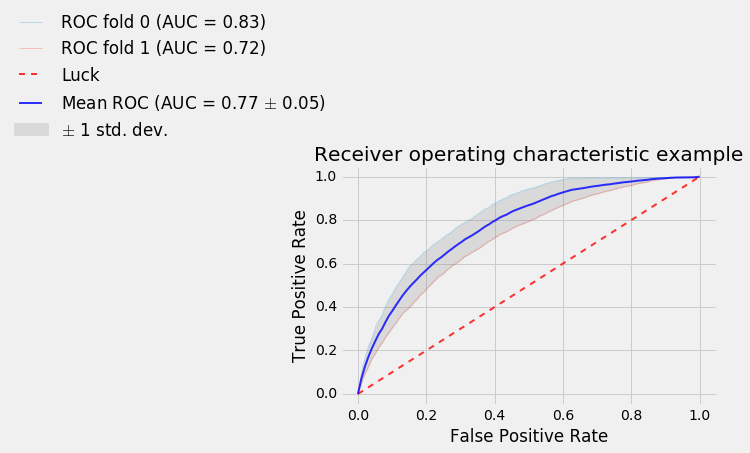

Random Forest Regression Classifier W/Cross validation takes 125.780008078 sec) 


In [310]:
""" Run classifier with cross-validation and plot ROC curves

"""
start = timeit.default_timer()
cv = StratifiedKFold(n_splits=1)
    #classifier = #svm.SVC(kernel='linear', probability=True, random_state=random_state)
classifier = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
#y_pred_RF_P = rnd.fit(X_train, y_train).predict_proba(X_test)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    ### CORRECTLY CALL X and y train with loc
    probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(bbox_to_anchor=(0, 1.7))
plt.show()
elapsed = timeit.default_timer() - start
print ("Random Forest Regression Classifier W/Cross \
       validation takes {} sec) ".format(round(elapsed,2))

# Measuremnt times

| classifier | folds | time
|--- | --- | : ---|
|random forest | 2 | 125 sec

In [289]:
#random forest
plt.figure()
pr_curve(y_test, rf1_pred_vec,'random forest')
pr_curve(y_test, lr_vec,'logistic regression')
gb1_pr=pr_curve(y_test,gb1_pred_vec, 'gradient boost')
#plt.savefig('pr');

NameError: name 'rf1_pred_vec' is not defined

In [ ]:
#################
### for predict_proba, use log-loss

# for col in X_train.columns:
#     print (col)
#     X_tr = X_train.loc[:, col].values.reshape(-1,1)
#     X_te = X_test.loc[:,col].values.reshape(-1,1)
#     lr_model = LogisticRegression()
#     lr_model.fit(X_tr, y_train)
#     y_prob_pred = lr_model.predict_proba(X_te)[:,1]
#     print( "log-loss",log_loss(y_test, y_prob_pred)) 

# Random forest + gradient boosting


In [290]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, log_loss


In [ ]:
"""
    train Classifiers first: y_pred_RF
"""
# print("accuracy \t",accuracy_score(y_test, y_pred_RF, normalize=True))
# print ("precision \t ", precision_score(y_test, y_pred_RF))
# print ("recall \t", recall_score(y_test, y_pred_RF))
# print ('f1 \t',f1_score(y_test, y_pred_RF))

Notes
+ recall is improved when max_features is increased
+ n_estimators : does not seem to have an affect


In [291]:
start = timeit.default_timer()
rnd = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
y_pred_RF_P = rnd.fit(X_train, y_train).predict_proba(X_test)
elapsed = timeit.default_timer() - start
print ("Random Forest Classifier takes {} sec) ".format(elapsed))

Random Forest Classifier takes 57.0064389706 sec) 


#### Top-10 Feature importances of Random Forest classifier

In [275]:
rnd_final = get_feature_importances(rnd)

In [277]:

rnd_final[:10]

,feature,importance,short_title,long_title
0,age,0.598025,NaN,NaN
1,admission_type,0.261654,NaN,NaN
2,1972,0.022091,Second malig neo pleura,Secondary malignant neoplasm of pleura
3,99685,0.015812,Compl marrow transplant,Complications of transplanted bone marrow
4,51181,0.010167,Malignant pleural effusn,Malignant pleural effusion
5,1984,0.009926,Sec malig neo nerve NEC,Secondary malignant neoplasm of other parts of...
6,gender,0.007559,NaN,NaN
7,485,0.006675,Bronchopneumonia org NOS,"Bronchopneumonia, organism unspecified"
8,20510,0.005248,Ch myl leuk wo achv rmsn,"Chronic myeloid leukemia, without mention of h..."
9,1971,0.004963,Sec mal neo mediastinum,Secondary malignant neoplasm of mediastinum


In [276]:
y_pred_RF_P = rnd.fit(X_train, y_train).predict_proba(X_test)

# print("accuracy \t",accuracy_score(y_test, y_pred_RF_P, normalize=True))
# print ("precision \t ", precision_score(y_test, y_pred_RF_P))
# print ("recall \t", recall_score(y_test, y_pred_RF_P))
# print ('f1 \t',f1_score(y_test, y_pred_RF_P))

In [ ]:
y_pred_RF_P.shape

In [ ]:
#second column 
rf1_pred_vec = y_pred_RF_P[:,1]

In [ ]:
plt.figure()
pr_curve(y_test, rf1_pred_vec);

In [ ]:
np.mean(y_test)

In [ ]:
roc_auc_score(y_test,rf1_pred_vec)

a possible way of interpreting this model : 
if I want to isolate a group of patients in the ICU with 80% precision, (80 TP/ 20 FP), so that 4/5ths have high mortality (are likely to die / WILL die) for special care, I can do this with 20% recall (Meaning we will catch only 20% of all patients who will die) 

If we want to catch more of the total patients who will die (Higher recall) 

In [ ]:
model_gb1 = GradientBoostingClassifier(n_estimators=4000,max_depth=3,learning_rate=.003)
model_gb1.fit(X_train, y_train)

In [ ]:

# predict class labels for the test set
gb1_pred_mat = model_gb1.predict_proba(X_test)
gb1_pred_vec = gb1_pred_mat[:,1]

In [ ]:
a = list(zip(X.columns, model_gb1.feature_importances_))

In [ ]:
a.sort(key=lambda tup: tup[1]) 
a

In [ ]:
('85225', 0.023728398524586445),
 ('58281', 0.02449622482246934),
 ('6829', 0.024804630629938505),
 ('20510', 0.025198270897120314),
 ('1971', 0.02572697097360083),
 ('07041', 0.025937043632540509),
 ('485', 0.031539383481972216),
 ('51181', 0.032793101127143578),
 ('99685', 0.03296745209222874),
 ('1984', 0.037243108801294431),
 ('1972', 0.04072702054898935),
 ('admission_type', 0.054172788832846458),
 ('age', 0.30028027265805535)]

In [ ]:
age, 0.3

In [ ]:
roc_auc_score(y_test,gb1_pred_vec)


In [ ]:
gb1_pr=pr_curve(y_test,gb1_pred_vec, 'gradient boost');
